In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo")
import turing as tu
from turing.utils import *
import turing.loss_functions as tu_loss

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
def print_vals(name, value, actual=None):    
    
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
def print_model(model, D_a = 0.005, D_s = 0.2, kappa_def = 0.25, sigma_s_def= 0.02):
    
    
    sigma_s = model.losses[1].sigma_s.numpy()[0]
    rho_s = model.losses[1].rho_s.numpy()[0]

    sigma_a = model.losses[1].sigma_a.numpy()[0]
    rho_a = model.losses[1].rho_a.numpy()[0]
    mu_a = model.losses[1].mu_a.numpy()[0]
    kappa_a = model.losses[1].kappa_a.numpy()[0]



    print_vals("sigma_s", sigma_s*D_s, sigma_s_def)
    print_vals("rho_s", rho_s*D_s, 0.02)
    print()    
    print_vals("sigma_a", sigma_a*D_a, 0.0)
    print_vals("rho_a", rho_a*D_a,0.01)
    print_vals("mu_a", mu_a*D_a, 0.01 )
    print_vals("kappa_a", kappa_a, kappa_def)

In [3]:
def create_dataset(data,
                   t_star,
                   N,
                   T,
                   L,
                   training_data_size,
                   pde_data_size,
                   boundary_data_size,
                   with_boundary = True,
                   signal_to_noise = 0):
    x_size = data.shape[1]
    y_size = data.shape[2]
    x_domain = L*np.linspace(0,1,x_size)
    y_domain = L*np.linspace(0,1,y_size)

    X,Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing='ij')
    XX = np.tile(X.flatten(), T) # N x T
    YY = np.tile(Y.flatten(), T) # N x T
    TT = np.repeat(t_star[-T:], N) # T x N

    AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
    SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


    x = XX[:, np.newaxis] # NT x 1
    y = YY[:, np.newaxis] # NT x 1
    t = TT[:, np.newaxis] # NT x 1

    a = AA[:, np.newaxis] # NT x 1
    s = SS[:, np.newaxis] # NT x 1

    boundary_x_LB = np.concatenate((x_domain, 
                                    np.repeat(x_domain[0], y_size)))
    boundary_x_RT = np.concatenate((x_domain, 
                                    np.repeat(x_domain[-1], y_size))) 

    boundary_y_LB = np.concatenate((np.repeat(y_domain[0], x_size),
                                    y_domain))
    boundary_y_RT = np.concatenate((np.repeat(y_domain[-1], x_size),
                                    y_domain)) 

    boundary_XX_LB = np.tile(boundary_x_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
    boundary_XX_RT = np.tile(boundary_x_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
    boundary_YY_LB = np.tile(boundary_y_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
    boundary_YY_RT = np.tile(boundary_y_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
    boundary_TT = np.repeat(t_star[-T:], (x_size + y_size))[:, np.newaxis] # T x (x_size + y_size), 1
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_a = (np.max(AA)-np.min(AA))/2.0
        signal_amp_s = (np.max(SS)-np.min(SS))/2.0  
        sigma_a =  signal_amp_a*signal_to_noise
        sigma_s =  signal_amp_s*signal_to_noise
    # Observed data
    idx_data = np.random.choice(N*T, training_data_size, replace=False)
    # PDE colocations
    idx_pde = np.random.choice(N*T, pde_data_size, replace=False)
    # Periodic boundary condition
    idx_boundary = np.random.choice((x_size + y_size)*T, boundary_data_size, replace=False)
    
    # Lower/Upper bounds
    lb, ub = lower_upper_bounds([np.c_[XX, YY, TT]])
    
    ret = {'obs_input': np.c_[XX[idx_data], YY[idx_data],TT[idx_data]],
           'obs_output': np.c_[AA[idx_data], SS[idx_data]],
           'pde':   np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]],
           'lb': lb,
           'ub': ub
          }
    
    if signal_to_noise > 0:        
        ret['obs_output'][0] += sigma_a * np.random.randn(len(idx_data), a.shape[1])
        ret['obs_output'][1] += sigma_s * np.random.randn(len(idx_data), s.shape[1])
    
    if with_boundary:
        ret = {**ret,
               **{'boundary_LB': np.c_[boundary_XX_LB[idx_boundary], 
                                       boundary_YY_LB[idx_boundary],
                                       boundary_TT[idx_boundary]],
                  'boundary_RT': np.c_[boundary_XX_RT[idx_boundary],
                                       boundary_YY_RT[idx_boundary],
                                       boundary_TT[idx_boundary]]
                 }
              }
    
    
    return ret    

# Dataset 4

In [4]:
layers = [3, 64, 64, 64, 64, 2]

data_path = os.path.abspath("turing_model_2.npy")
with open(data_path, 'rb') as f:
    data4 = np.load(f)
    
data_path = os.path.abspath("turing_t_model_2.npy")
with open(data_path, 'rb') as f:
    t_star4 = np.load(f) 
    
T4 = t_star4.shape[0]    
    
L4 = 50
x_size4 = data4.shape[1]
y_size4 = data4.shape[2]
N4 = x_size4*y_size4

In [5]:
model_params_4 = {'training_data_size': T4*32,
                'pde_data_size': (T4*N4)//(32),
                'boundary_data_size':((x_size4 + y_size4)*T4)//(8)}

dataset4 = create_dataset(data4, t_star4, N4, T4, L4, **model_params_4)
lb4 = dataset4['lb']
ub4 = dataset4['ub']
obs_X4 = dataset4['obs_input']
obs_Y4 = dataset4['obs_output']
pde_X4 = dataset4['pde']

In [6]:
pinn4 = tu.NN(layers, lb4, ub4)
loss_stack_4 = [tu_loss.Observations(pinn4, obs_X4, obs_Y4),
                tu_loss.schnakenberg2(pinn4, pde_X4)
               ]
model_4 = tu.TINN(pinn4, loss_stack_4, optimizer=keras.optimizers.Adam())

2022-06-29 12:20:25.595532: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-29 12:20:25.595602: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ld-rendres10
2022-06-29 12:20:25.595617: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ld-rendres10
2022-06-29 12:20:25.595711: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.33.1
2022-06-29 12:20:25.595760: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.33.1
2022-06-29 12:20:25.595772: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.33.1



- $c_0 = 1$
- $c_1 = 0.1$
- $c_2 = 0.9/40 = 0.0225$
- $c_3 = 1$
- $c_4 = 1/40 = 0.025$

In [7]:
arr_losses_4, samples_params_4, _ = \
         model_4.train(2000,
                       batch_size=dataset4['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold=0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:70729.71
Loss_observations:42332.10937500 
Loss_Schnakenberg:28397.60205078 c_0:0:9.99428749
Time:4.39

Epoch: 100, loss:43918.62
Loss_observations:38035.30908203 
Loss_Schnakenberg:5883.30987549 c_0:0:9.87572193
Time:30.95

Epoch: 200, loss:41895.45
Loss_observations:37697.79931641 
Loss_Schnakenberg:4197.65307617 c_0:0:9.64188290
Time:29.06

Epoch: 300, loss:41808.76
Loss_observations:37594.70361328 
Loss_Schnakenberg:4214.05307007 c_0:0:9.27493191
Time:26.99

Epoch: 400, loss:41766.71
Loss_observations:37627.69824219 
Loss_Schnakenberg:4139.01235962 c_0:0:8.74334908
Time:26.71

Epoch: 500, loss:41699.87
Loss_observations:37424.19433594 
Loss_Schnakenberg:4275.67382812 c_0:0:8.03197956
Time:27.03

Epoch: 600, loss:41501.98
Loss_observations:37232.55126953 
Loss_Schnakenberg:4269.42852783 c_0:0:7.16154003
Time:26.64

Epoch: 700, loss:41224.23
Loss_observations:36781.16601562 
Loss_Schnakenberg:4443.06756592 c_0:0:6.14140272
Time:27.80

Epoch: 800, loss:40670.38
Loss_obs


- $c_0 = 1$
- $c_1 = 0.1$
- $c_2 = 0.9/40 = 0.0225$
- $c_3 = 1$
- $c_4 = 1/40 = 0.025$

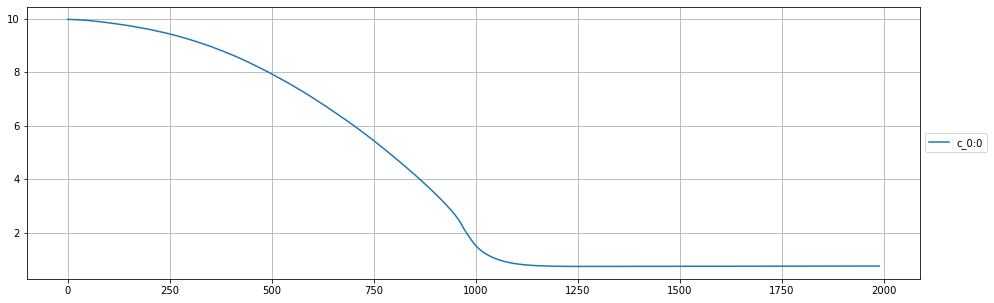

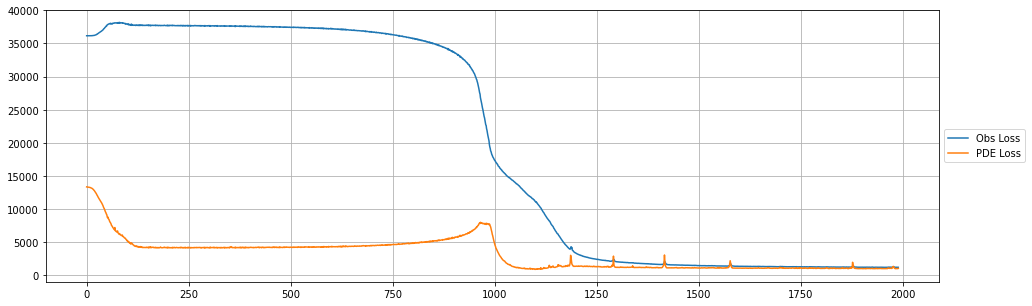

In [9]:
param_names = [v.name for v in loss_stack_4[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 10

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_4[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,4])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_4[start:,0], label="Obs Loss")
plt.plot(arr_losses_4[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,5000])

plt.show()

In [90]:
pinn6 = tu.NN(layers, lb4, ub4)
loss_stack_6 = [tu_loss.Observations(pinn6, obs_X4, obs_Y4, init_loss_weight=10.0),
                schnakenberg(pinn5, pde_X4)
               ]
model_6 = tu.TINN(pinn6, loss_stack_6, optimizer=keras.optimizers.Adam())

In [91]:
arr_losses_6, samples_params_6, _ = \
         model_6.train(1000,
                       batch_size=dataset4['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold=0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:1834169.75
Loss_observations:383477.78125000 
Loss_Schnakenberg:1450692.14062500 D_u:0:10.00799847, D_v:0:10.00799274, c_0:0:10.00799561, c_1:0:9.99200439, c_2:0:9.99199677
Time:1.48

Epoch: 100, loss:1406560.25
Loss_observations:195156.85937500 
Loss_Schnakenberg:1211403.54687500 D_u:0:10.40133381, D_v:0:10.78403854, c_0:0:10.39423370, c_1:0:9.60572910, c_2:0:9.21507168
Time:63.88

Epoch: 200, loss:1202316.50
Loss_observations:195049.31250000 
Loss_Schnakenberg:1007267.12500000 D_u:0:10.43755531, D_v:0:11.54094887, c_0:0:10.40644455, c_1:0:9.59340763, c_2:0:8.45734882
Time:64.32

Epoch: 300, loss:1021878.00
Loss_observations:194870.98046875 
Loss_Schnakenberg:827006.99218750 D_u:0:10.47763443, D_v:0:12.27615833, c_0:0:10.40640068, c_1:0:9.59334755, c_2:0:7.72130394
Time:64.24

Epoch: 400, loss:848475.12
Loss_observations:180240.11132812 
Loss_Schnakenberg:668234.94531250 D_u:0:10.53981304, D_v:0:12.99354744, c_0:0:10.40626812, c_1:0:9.59322071, c_2:0:7.00309229
Time:64.

- $D_u = 1.0$
- $D_v = 40$
- $c_0 = 1.0$
- $c_1 = 0.1$
- $c_2 = 0.9$
- $c_3 = 1.0$

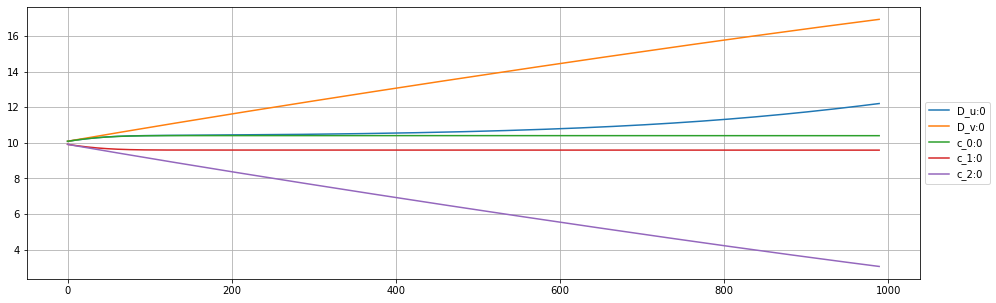

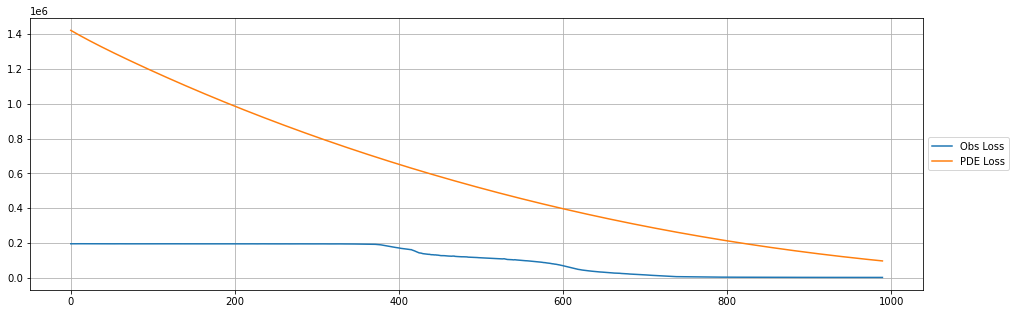

In [93]:
param_names = [v.name for v in loss_stack_6[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 10

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_6[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,4])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_6[start:,0], label="Obs Loss")
plt.plot(arr_losses_6[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,1000])

plt.show()

In [94]:
arr_losses_7, samples_params_7, _ = \
         model_6.train(2000,
                       batch_size=dataset4['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold=0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:98324.34
Loss_observations:1903.50634766 
Loss_Schnakenberg:96420.83203125 D_u:0:12.21526814, D_v:0:16.94830322, c_0:0:10.40175343, c_1:0:9.58886623, c_2:0:3.04328132
Time:0.60

Epoch: 100, loss:58389.43
Loss_observations:1663.97488403 
Loss_Schnakenberg:56725.45703125 D_u:0:12.84357548, D_v:0:17.51239014, c_0:0:10.39940357, c_1:0:9.58649445, c_2:0:2.47828388
Time:70.66

Epoch: 200, loss:30754.79
Loss_observations:1526.61576843 
Loss_Schnakenberg:29228.17407227 D_u:0:13.55318165, D_v:0:18.03615570, c_0:0:10.39581203, c_1:0:9.58297253, c_2:0:1.95348871
Time:69.76

Epoch: 300, loss:13893.88
Loss_observations:1412.54395294 
Loss_Schnakenberg:12481.33813477 D_u:0:14.30701351, D_v:0:18.49744034, c_0:0:10.39060593, c_1:0:9.57764244, c_2:0:1.49100912
Time:69.97

Epoch: 400, loss:5357.81
Loss_observations:1360.47483826 
Loss_Schnakenberg:3997.33764648 D_u:0:15.08359051, D_v:0:18.87432861, c_0:0:10.38265514, c_1:0:9.57014561, c_2:0:1.11256123
Time:70.17

Epoch: 500, loss:2096.65


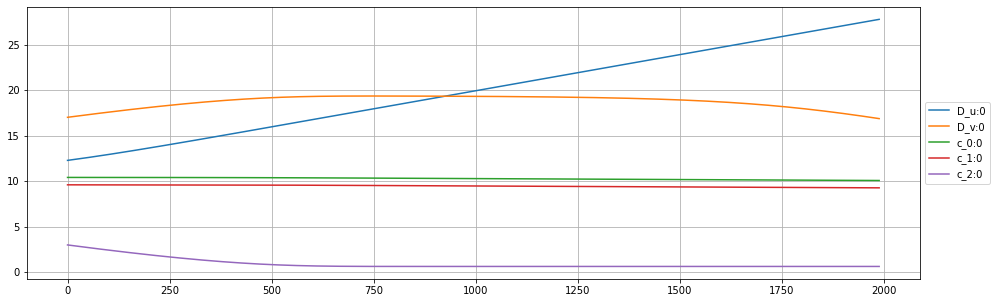

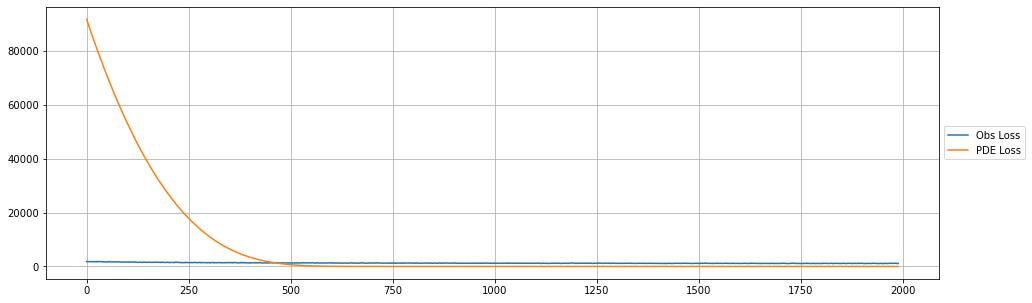

In [95]:
param_names = [v.name for v in loss_stack_6[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 10

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_7[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,4])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_7[start:,0], label="Obs Loss")
plt.plot(arr_losses_7[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,1000])

plt.show()

In [96]:
x_2 = L*np.linspace(0,1,x_size4)
y_2 = L*np.linspace(0,1,y_size4)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1#-1
t_test = 50000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N4) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [97]:
uv_2 = pinn6(np.hstack([x_2, y_2, t_2]), False)
u_2 = uv_2[:, 0].numpy()
v_2 = uv_2[:, 1].numpy()
u_2 = u_2.reshape((x_size4,y_size4))
v_2 = v_2.reshape((x_size4,y_size4))

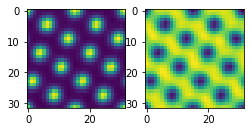

In [98]:
plt.subplot(131)
plt.imshow(u_2)
plt.subplot(132)
plt.imshow(v_2)
plt.show()

In [99]:
UU = np.einsum('ijk->kij', data4[0, :, :, -t_test:]) # T x x_size x y_size
VV = np.einsum('ijk->kij', data4[1, :, :, -t_test:]) # T x x_size x y_size

In [100]:
L_obs = 0
for i,T in enumerate(t_star4):
    TT_2 = np.array([T]*N4) # N
    t_2 = TT_2[:, np.newaxis] # N x 1
    uv_2 = pinn6(np.hstack([x_2, y_2, t_2]), False)
    u_2 = uv_2[:, 0].numpy()
    v_2 = uv_2[:, 1].numpy()
    u_2 = u_2.reshape((x_size4,y_size4))
    v_2 = v_2.reshape((x_size4,y_size4))
    L_obs += np.sum(np.square(u_2 - UU[i,:, :])) + np.sum(np.square(v_2 - VV[i,:, :]))
    

In [101]:
np.sqrt(L_obs/10)/(512*32*32)

4.30541163844145e-05

In [102]:
arr_losses_8, samples_params_8, _ = \
         model_6.train(1000,
                       batch_size=dataset4['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold=0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:1096.62
Loss_observations:1092.47930908 
Loss_Schnakenberg:4.14113355 D_u:0:27.77779007, D_v:0:16.85721016, c_0:0:10.06413364, c_1:0:9.25753975, c_2:0:0.62071997
Time:0.55

Epoch: 100, loss:1145.67
Loss_observations:1141.54853058 
Loss_Schnakenberg:4.11662418 D_u:0:28.56313896, D_v:0:16.15670967, c_0:0:10.04290199, c_1:0:9.23713875, c_2:0:0.62071574
Time:76.39

Epoch: 200, loss:1130.48
Loss_observations:1126.38321686 
Loss_Schnakenberg:4.09717026 D_u:0:29.35651398, D_v:0:15.40578270, c_0:0:10.02190971, c_1:0:9.21556759, c_2:0:0.62077141
Time:71.77

Epoch: 300, loss:1057.02
Loss_observations:1052.93722534 
Loss_Schnakenberg:4.07948098 D_u:0:30.14978600, D_v:0:14.63234806, c_0:0:9.99983692, c_1:0:9.19500637, c_2:0:0.62074912
Time:67.71

Epoch: 400, loss:1104.89
Loss_observations:1100.83106995 
Loss_Schnakenberg:4.05575168 D_u:0:30.94311714, D_v:0:13.84807396, c_0:0:9.97876835, c_1:0:9.17377186, c_2:0:0.62065291
Time:68.03

Epoch: 500, loss:1091.51
Loss_observations:1087.47

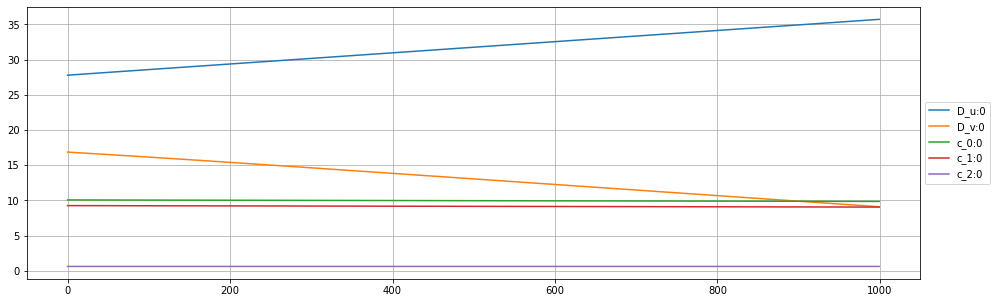

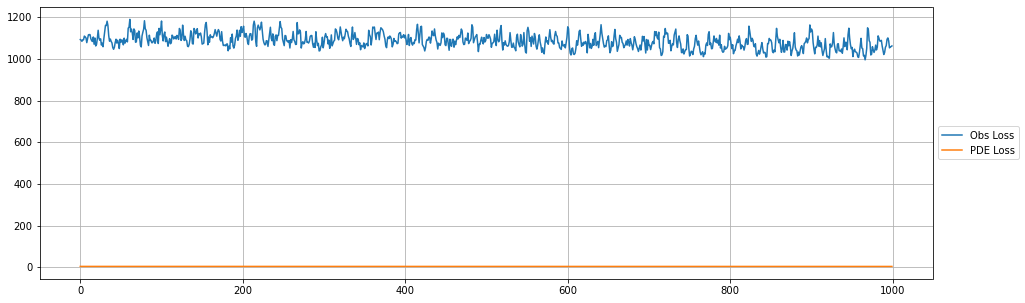

In [107]:
param_names = [v.name for v in loss_stack_4[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_8[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,4])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_8[start:,0], label="Obs Loss")
plt.plot(arr_losses_8[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,10])

plt.show()

In [109]:
class schnakenberg2(tu_loss.Truing_PDE):
    def __init__(self, 
                 pinn, 
                 inputs_pde, 
                 init_loss_weight = 1.0,
                 #D_u = 10.0,
                 #D_v = 10.0,
                 c_0 = 10.0#,
                 #c_1 = 10.0,
                 #c_2 = 10.0                 
                ):
        super().__init__(pinn, inputs_pde, name="Loss_Schnakenberg", init_loss_weight= init_loss_weight)
        
        #self.D_u = tf.Variable([D_u], dtype=tf.float32,
        #                           name="D_u",
        #                           constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        #self.D_v = tf.Variable([D_v], dtype=tf.float32,
        #                           name="D_v",
        #                           constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.c_0 = tf.Variable([c_0], dtype=tf.float32,
                                   name="c_0",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
#         self.c_1 = tf.Variable([c_1], dtype=tf.float32, 
#                                    name="c_1",
#                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
#         self.c_2 = tf.Variable([c_2], dtype=tf.float32, 
#                                 name="c_2",
#                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
        
        
    def trainable_vars(self):
        return [#self.D_u,
                #self.D_v,
                self.c_0,
                #self.c_1,                
                #self.c_2
               ]
        
    def pde(self, outputs, partials_1, partials_2):
        u = outputs[:, 0]
        v = outputs[:, 1]
        
        u_x = partials_1[0][:, 0]
        u_y = partials_1[0][:, 1]
        u_t = partials_1[0][:, 2]
        
        u_xx = partials_2[0][:, 0]
        u_yy = partials_2[0][:, 1]
        
        
        v_x = partials_1[1][:, 0]
        v_y = partials_1[1][:, 1]
        v_t = partials_1[1][:, 2]
        
        v_xx = partials_2[1][:, 0]
        v_yy = partials_2[1][:, 1]
        
        #D_u = self.D_u
        #D_v = self.D_v
        c_0 = self.c_0
        #c_1 = self.c_1
        #c_2 = self.c_2
               
        
        u2v = u*u*v
        f_u = u_t - 1.0*(u_xx + u_yy) - 0.1 + c_0*u -  u2v
        f_v = v_t - 40.0*(v_xx + v_yy) - 0.9 + u2v
        
        return tf.concat([tf.expand_dims(f_u, axis=1), 
                          tf.expand_dims(f_v, axis=1)], axis = 1)

In [112]:
pinn9 = tu.NN(layers, lb4, ub4)
loss_stack_9 = [tu_loss.Observations(pinn9, obs_X4, obs_Y4),
                schnakenberg2(pinn9, pde_X4)
               ]
model_9 = tu.TINN(pinn9, loss_stack_9, optimizer=keras.optimizers.Adam())

In [113]:
arr_losses_9, samples_params_9, _ = \
         model_9.train(2000,
                       batch_size=dataset4['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold=0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:68371.06
Loss_observations:40733.97802734 
Loss_Schnakenberg:27637.08886719 c_0:0:9.99433422
Time:1.83

Epoch: 100, loss:47887.27
Loss_observations:34539.33789062 
Loss_Schnakenberg:13347.93286133 c_0:0:9.89167404
Time:69.87

Epoch: 200, loss:47893.39
Loss_observations:34519.97753906 
Loss_Schnakenberg:13373.41333008 c_0:0:9.67602634
Time:65.48

Epoch: 300, loss:47888.84
Loss_observations:34482.13793945 
Loss_Schnakenberg:13406.70068359 c_0:0:9.31594372
Time:69.45

Epoch: 400, loss:47854.46
Loss_observations:34414.33959961 
Loss_Schnakenberg:13440.12280273 c_0:0:8.77051640
Time:68.19

Epoch: 500, loss:47794.18
Loss_observations:34302.85156250 
Loss_Schnakenberg:13491.32714844 c_0:0:8.02111816
Time:67.69

Epoch: 600, loss:47674.78
Loss_observations:34110.53320312 
Loss_Schnakenberg:13564.24719238 c_0:0:7.09402847
Time:70.27

Epoch: 700, loss:47475.95
Loss_observations:33804.84814453 
Loss_Schnakenberg:13671.10095215 c_0:0:6.03375769
Time:68.74

Epoch: 800, loss:47105.49
L

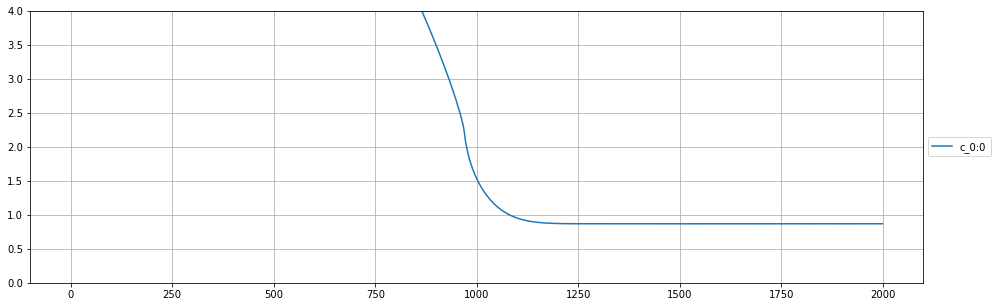

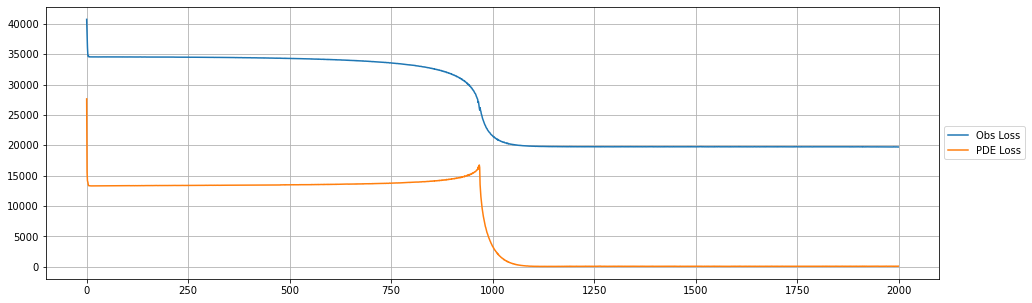

In [115]:
param_names = [v.name for v in loss_stack_9[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_9[start:,j], label=f"{param_names[j]}")

plt.ylim([0,4])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_9[start:,0], label="Obs Loss")
plt.plot(arr_losses_9[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,10])

plt.show()

In [116]:
pinn10 = tu.NN(layers, lb4, ub4)
loss_stack_10 = [tu_loss.Observations(pinn10, obs_X4, obs_Y4, init_loss_weight=10.0),
                schnakenberg2(pinn10, pde_X4)
               ]
model_10 = tu.TINN(pinn10, loss_stack_10, optimizer=keras.optimizers.Adam())

In [117]:
arr_losses_10, samples_params_10, _ = \
         model_10.train(2000,
                       batch_size=dataset4['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold=0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:410413.69
Loss_observations:390579.56640625 
Loss_Schnakenberg:19834.12243652 c_0:0:9.99253845
Time:1.68

Epoch: 100, loss:344772.34
Loss_observations:316257.48046875 
Loss_Schnakenberg:28514.88867188 c_0:0:9.16224575
Time:70.35

Epoch: 200, loss:340836.50
Loss_observations:309632.32031250 
Loss_Schnakenberg:31204.20336914 c_0:0:8.24470997
Time:68.90

Epoch: 300, loss:335103.97
Loss_observations:299439.51171875 
Loss_Schnakenberg:35664.47802734 c_0:0:7.25441551
Time:72.01

Epoch: 400, loss:326328.97
Loss_observations:285859.06640625 
Loss_Schnakenberg:40469.89160156 c_0:0:6.19888401
Time:73.28

Epoch: 500, loss:312229.25
Loss_observations:265152.43164062 
Loss_Schnakenberg:47076.83837891 c_0:0:5.08141804
Time:72.45

Epoch: 600, loss:287755.78
Loss_observations:234488.66406250 
Loss_Schnakenberg:53267.11621094 c_0:0:3.90257335
Time:71.00

Epoch: 700, loss:244426.84
Loss_observations:201392.86914062 
Loss_Schnakenberg:43033.96777344 c_0:0:2.71219945
Time:72.21

Epoch: 800,

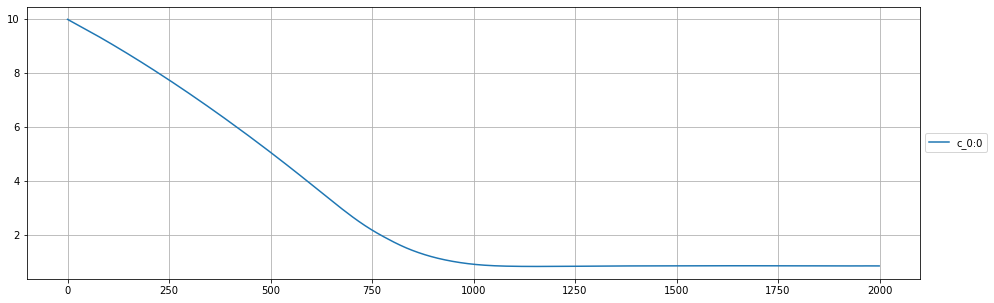

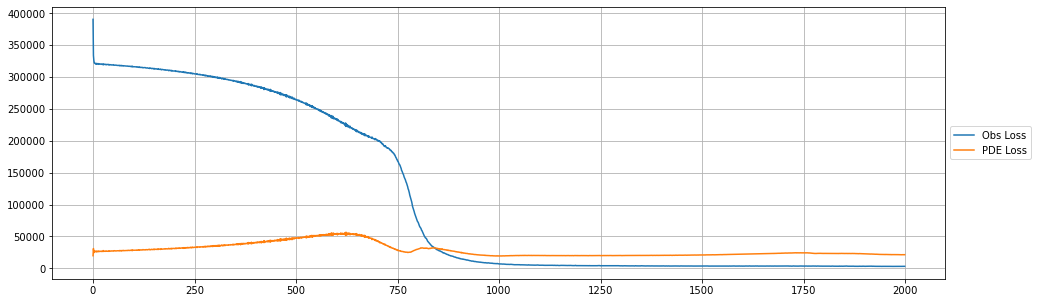

In [121]:
param_names = [v.name for v in loss_stack_9[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_10[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,4])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_10[start:,0], label="Obs Loss")
plt.plot(arr_losses_10[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,10])

plt.show()

In [118]:
arr_losses_11, samples_params_11, _ = \
         model_10.train(4000,
                       batch_size=dataset4['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold=0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:24553.21
Loss_observations:3182.86276245 
Loss_Schnakenberg:21370.34375000 c_0:0:0.86458355
Time:0.50

Epoch: 100, loss:23637.12
Loss_observations:2902.48217773 
Loss_Schnakenberg:20734.63159180 c_0:0:0.86411518
Time:65.13

Epoch: 200, loss:22430.19
Loss_observations:2751.45385742 
Loss_Schnakenberg:19678.73779297 c_0:0:0.86492729
Time:72.83

Epoch: 300, loss:22026.64
Loss_observations:2715.28829956 
Loss_Schnakenberg:19311.35424805 c_0:0:0.86538470
Time:69.82

Epoch: 400, loss:21719.25
Loss_observations:2699.82803345 
Loss_Schnakenberg:19019.42382812 c_0:0:0.86771995
Time:69.77

Epoch: 500, loss:21182.63
Loss_observations:2493.09716797 
Loss_Schnakenberg:18689.53100586 c_0:0:0.86706799
Time:69.94

Epoch: 600, loss:20893.41
Loss_observations:2462.35919189 
Loss_Schnakenberg:18431.05102539 c_0:0:0.86798739
Time:70.69

Epoch: 700, loss:20640.29
Loss_observations:2448.16674805 
Loss_Schnakenberg:18192.11791992 c_0:0:0.86890161
Time:70.21

Epoch: 800, loss:20329.29
Loss_obse

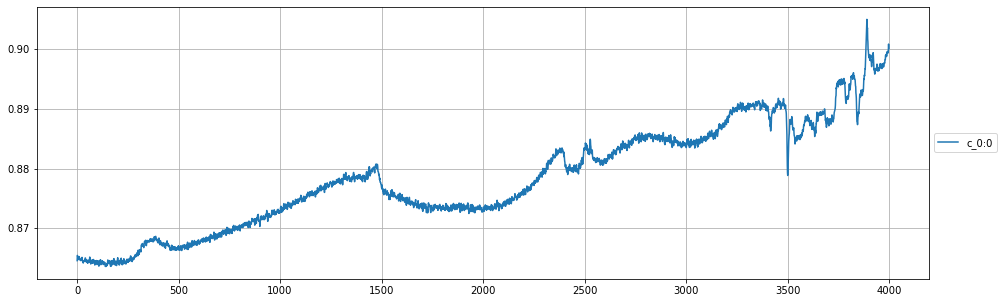

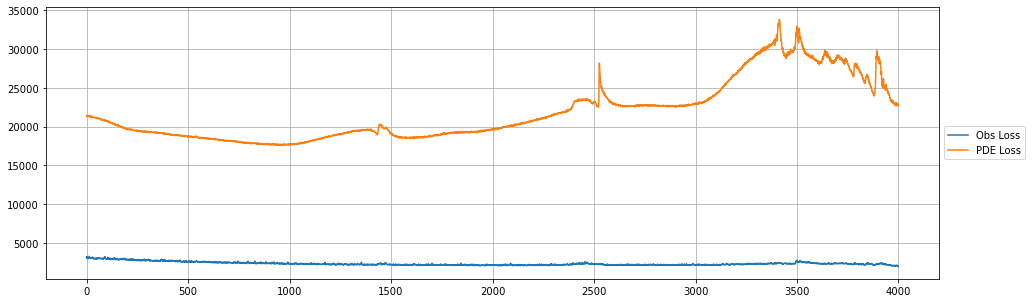

In [120]:
param_names = [v.name for v in loss_stack_9[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 0

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_11[start:,j], label=f"{param_names[j]}")

#plt.ylim([0,4])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_11[start:,0], label="Obs Loss")
plt.plot(arr_losses_11[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,10])

plt.show()

In [124]:
arr_losses = np.vstack([arr_losses_10,arr_losses_11])
samples_params = np.vstack([samples_params_10,samples_params_11])

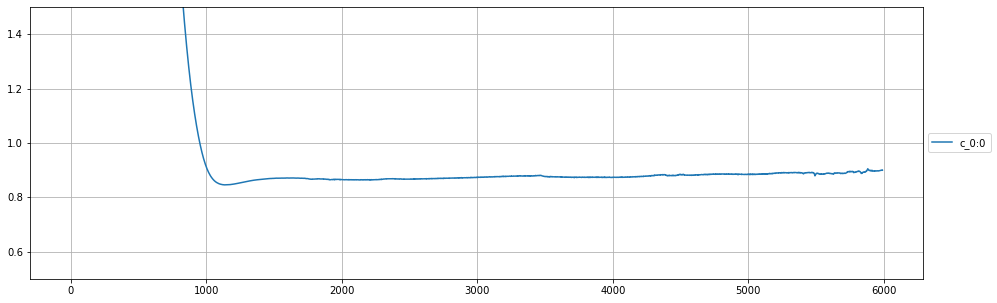

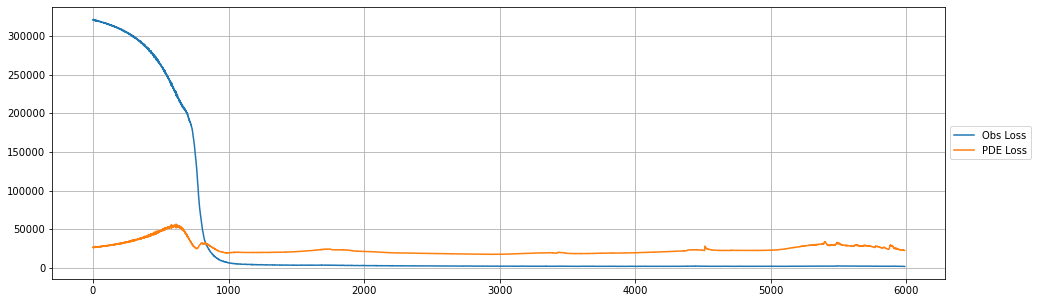

In [130]:
param_names = [v.name for v in loss_stack_9[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 10

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params[start:,j], label=f"{param_names[j]}")

plt.ylim([0.5,1.5])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses[start:,0], label="Obs Loss")
plt.plot(arr_losses[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim([0,10])

plt.show()

In [131]:
arr_losses_12, samples_params_12, _ = \
         model_10.train(4000,
                       batch_size=dataset4['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold=0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:24809.12
Loss_observations:1969.77235413 
Loss_Schnakenberg:22839.35375977 c_0:0:0.90015972
Time:0.55

Epoch: 100, loss:26914.96
Loss_observations:2079.35937500 
Loss_Schnakenberg:24835.59741211 c_0:0:0.90357983
Time:73.21

Epoch: 200, loss:25105.18
Loss_observations:2040.23524475 
Loss_Schnakenberg:23064.94799805 c_0:0:0.90148234
Time:74.84

Epoch: 300, loss:24518.51
Loss_observations:2005.92790222 
Loss_Schnakenberg:22512.58349609 c_0:0:0.90882045
Time:70.68

Epoch: 400, loss:25162.68
Loss_observations:1950.64663696 
Loss_Schnakenberg:23212.03295898 c_0:0:0.90910751
Time:72.90

Epoch: 500, loss:25019.66
Loss_observations:1917.36355591 
Loss_Schnakenberg:23102.29882812 c_0:0:0.90963465
Time:73.92

Epoch: 600, loss:24661.92
Loss_observations:1968.19029236 
Loss_Schnakenberg:22693.72827148 c_0:0:0.90740293
Time:75.12

Epoch: 700, loss:25545.82
Loss_observations:1945.41134644 
Loss_Schnakenberg:23600.40942383 c_0:0:0.90992391
Time:75.95

Epoch: 800, loss:25048.41
Loss_obse

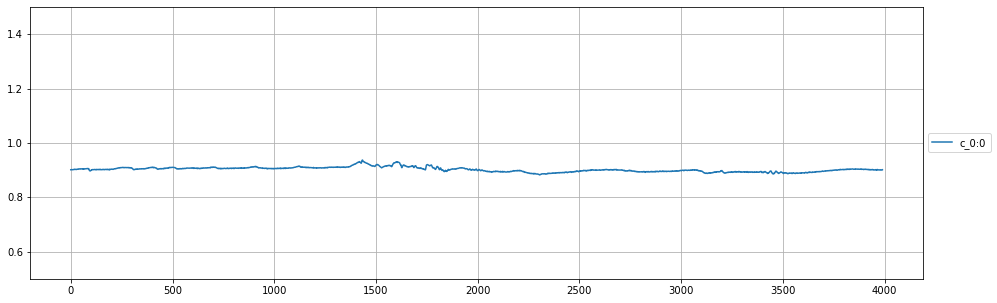

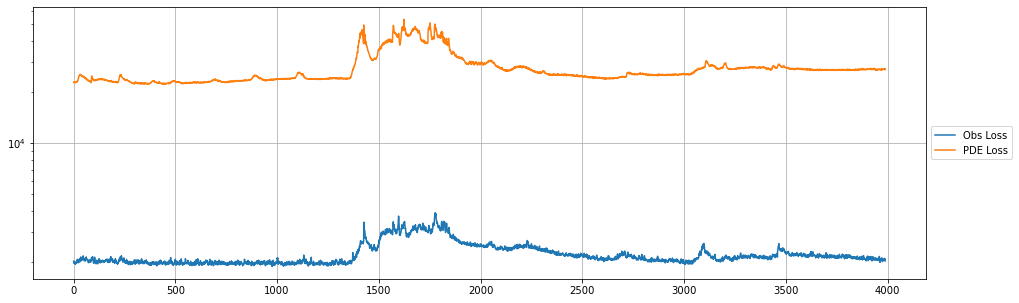

In [133]:
param_names = [v.name for v in loss_stack_9[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 10

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_12[start:,j], label=f"{param_names[j]}")

plt.ylim([0.5,1.5])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_12[start:,0], label="Obs Loss")
plt.plot(arr_losses_12[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
#plt.ylim([0,10])

plt.show()

In [134]:
layers2 = [3, 128, 128, 128, 128, 2]

In [136]:
pinn_2 = tu.NN(layers2, lb4, ub4)
loss_stack_2_1 = [tu_loss.Observations(pinn_2, obs_X4, obs_Y4, init_loss_weight=10.0),
                schnakenberg2(pinn_2, pde_X4)
               ]
model_2_1 = tu.TINN(pinn_2, loss_stack_2_1, optimizer=keras.optimizers.Adam())

In [137]:
arr_losses_2_1, samples_params_2_1, _ = \
         model_2_1.train(10000,
                       batch_size=dataset4['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold=0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:413068.94
Loss_observations:377618.40234375 
Loss_Schnakenberg:35450.52441406 c_0:0:9.99210167
Time:1.87

Epoch: 100, loss:344905.59
Loss_observations:316845.89062500 
Loss_Schnakenberg:28059.71484375 c_0:0:9.19025326
Time:86.48

Epoch: 200, loss:341062.56
Loss_observations:309920.75781250 
Loss_Schnakenberg:31141.79492188 c_0:0:8.27806187
Time:86.12

Epoch: 300, loss:335371.03
Loss_observations:300628.76953125 
Loss_Schnakenberg:34742.26806641 c_0:0:7.29076719
Time:85.02

Epoch: 400, loss:326832.38
Loss_observations:286938.70312500 
Loss_Schnakenberg:39893.67822266 c_0:0:6.23720264
Time:85.79

Epoch: 500, loss:312966.88
Loss_observations:264763.40234375 
Loss_Schnakenberg:48203.47705078 c_0:0:5.12117195
Time:88.01

Epoch: 600, loss:288868.94
Loss_observations:235838.07421875 
Loss_Schnakenberg:53030.85937500 c_0:0:3.94368958
Time:82.95

Epoch: 700, loss:247890.70
Loss_observations:203270.22070312 
Loss_Schnakenberg:44620.48095703 c_0:0:2.75031424
Time:86.44

Epoch: 800,

Epoch: 6700, loss:51581.98
Loss_observations:2799.68878174 
Loss_Schnakenberg:48782.28662109 c_0:0:0.89793247
Time:87.34

Epoch: 6800, loss:52558.37
Loss_observations:2624.50054932 
Loss_Schnakenberg:49933.87060547 c_0:0:0.86341786
Time:89.14

Epoch: 6900, loss:52128.32
Loss_observations:2793.00964355 
Loss_Schnakenberg:49335.31396484 c_0:0:0.89914817
Time:89.48

Epoch: 7000, loss:54895.57
Loss_observations:3035.97500610 
Loss_Schnakenberg:51859.60058594 c_0:0:0.90049839
Time:93.50

Epoch: 7100, loss:57231.25
Loss_observations:2756.16848755 
Loss_Schnakenberg:54475.08154297 c_0:0:0.90332174
Time:92.36

Epoch: 7200, loss:61487.68
Loss_observations:3603.54638672 
Loss_Schnakenberg:57884.13916016 c_0:0:0.89403725
Time:89.27

Epoch: 7300, loss:61932.07
Loss_observations:3463.73623657 
Loss_Schnakenberg:58468.33154297 c_0:0:0.88940656
Time:90.73

Epoch: 7400, loss:64564.82
Loss_observations:3548.81768799 
Loss_Schnakenberg:61016.00488281 c_0:0:0.88992095
Time:89.93

Epoch: 7500, loss:62070.

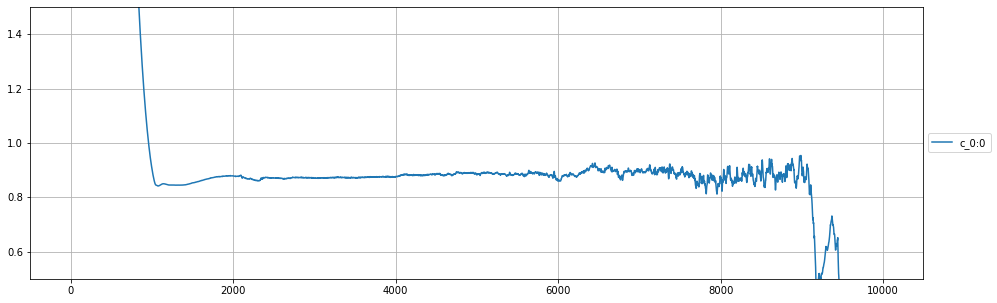

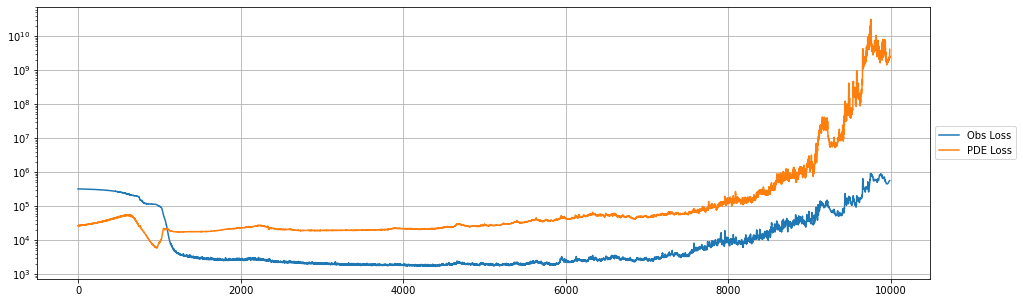

In [138]:
param_names = [v.name for v in loss_stack_2_1[1].trainable_vars()]
params_len = len(param_names)
W_n = len(layers)-1

start = 10

_ = plt.figure(figsize=(16,5))
#plt.subplot(2,1,1)
for j in range(params_len):
    plt.plot(samples_params_2_1[start:,j], label=f"{param_names[j]}")

plt.ylim([0.5,1.5])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.subplot(2,1,2)
fig = plt.figure(figsize=(16,5))
fig.patch.set_facecolor('white')
plt.plot(arr_losses_2_1[start:,0], label="Obs Loss")
plt.plot(arr_losses_2_1[start:,1], label="PDE Loss")
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
#plt.ylim([0,10])

plt.show()

In [139]:
uv_2 = pinn_2(np.hstack([x_2, y_2, t_2]), False)
u_2 = uv_2[:, 0].numpy()
v_2 = uv_2[:, 1].numpy()
u_2 = u_2.reshape((x_size4,y_size4))
v_2 = v_2.reshape((x_size4,y_size4))

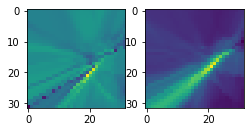

In [140]:
plt.subplot(131)
plt.imshow(u_2)
plt.subplot(132)
plt.imshow(v_2)
plt.show()

In [141]:
pinn_2_2 = tu.NN(layers, lb4, ub4)
loss_stack_2_2 = [tu_loss.Observations(pinn_2_2, obs_X4, obs_Y4)
               ]
model_2_2 = tu.TINN(pinn_2_2, loss_stack_2_2, optimizer=keras.optimizers.Adam())

In [142]:
arr_losses_2_2, samples_params_2_2, _ = \
         model_2_2.train(1000,
                       batch_size=dataset4['obs_input'].shape[0]//8, 
                       print_iter=100,
                       stop_threshold=0,
                       regularised=False,
                       regularisation_freq=10,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=False)

Epoch: 1, loss:38557.87
Loss_observations:38557.86962891 
Time:0.54

Epoch: 100, loss:19519.05
Loss_observations:19519.05541992 
Time:35.31

Epoch: 200, loss:19503.88
Loss_observations:19503.88427734 
Time:39.39

Epoch: 300, loss:19500.93
Loss_observations:19500.92602539 
Time:42.14

Epoch: 400, loss:19446.42
Loss_observations:19446.42504883 
Time:39.94

Epoch: 500, loss:19372.89
Loss_observations:19372.88940430 
Time:39.56

Epoch: 600, loss:11445.70
Loss_observations:11445.69909668 
Time:38.48

Epoch: 700, loss:2610.63
Loss_observations:2610.62844849 
Time:41.32

Epoch: 800, loss:853.31
Loss_observations:853.30948639 
Time:40.86

Epoch: 900, loss:391.67
Loss_observations:391.66945648 
Time:43.61

Epoch: 1000, loss:305.99
Loss_observations:305.98926353 
Time:43.42



In [143]:
uv_2 = pinn_2_2(np.hstack([x_2, y_2, t_2]), False)
u_2 = uv_2[:, 0].numpy()
v_2 = uv_2[:, 1].numpy()
u_2 = u_2.reshape((x_size4,y_size4))
v_2 = v_2.reshape((x_size4,y_size4))

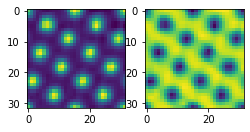

In [144]:
plt.subplot(131)
plt.imshow(u_2)
plt.subplot(132)
plt.imshow(v_2)
plt.show()